# House Prices: Advanced Regression Techniques (Part 1 - Exploration)

In this notebook we apply linear regression to some data from a Kaggle. The notebook is divided into two sections. First we perform some in-depth data exploration and pre-processing, next we build the actual models.

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

This notebook is derived from other existing notebooks by other authors, like,

- https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

First we import some of the libraries we will need:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
all_data = pd.read_csv("HousePricesInputVariables.csv")

In [5]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Missing Values
Let's check how many missing values are in the data set and how can we deal with them. 

In [8]:
# Obtain, for each attribute, the amount of missing values
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
# Drop the attributes that has zero missing values (full information)
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head(30)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageYrBlt,5.447071
GarageQual,5.447071
GarageCond,5.447071


In [9]:
all_data_na.index[:10]

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageFinish', 'GarageYrBlt', 'GarageQual', 'GarageCond'],
      dtype='object')

Text(0.5, 1.0, 'Top Variables for % of Missing Values')

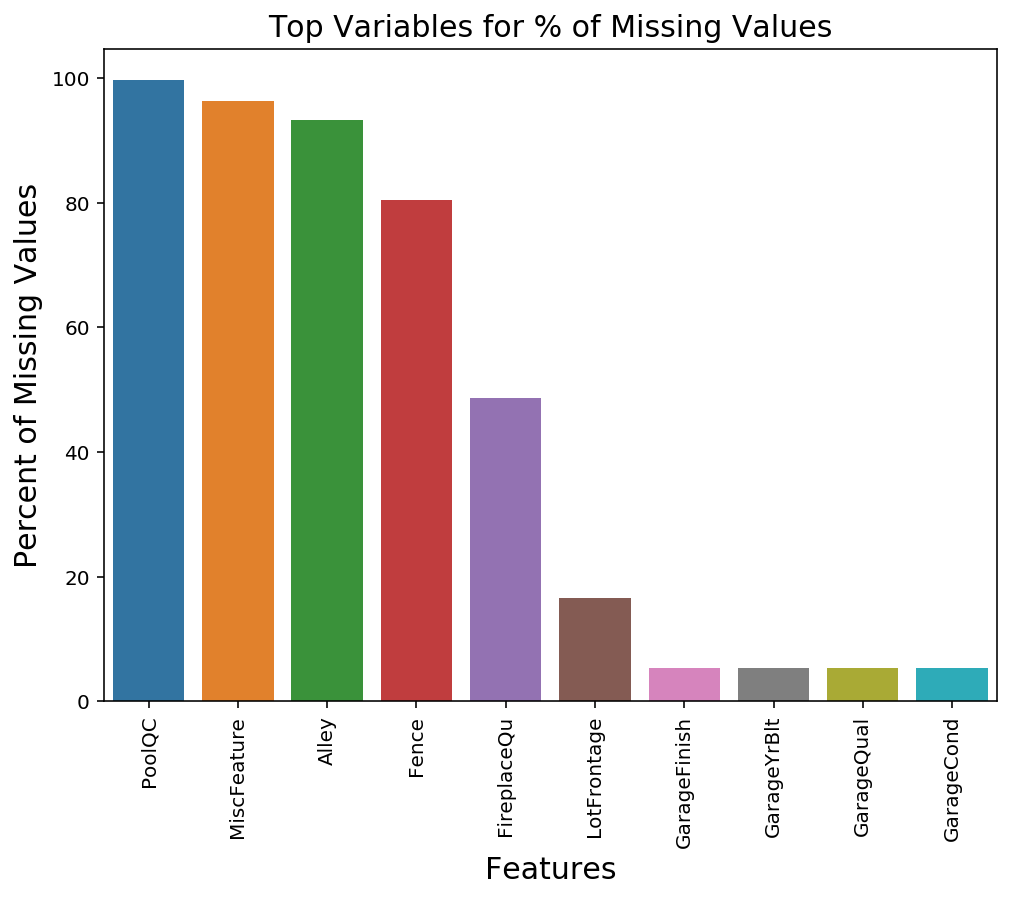

In [12]:
f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index[:10], y=all_data_na[:10])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Top Variables for % of Missing Values', fontsize=15)

We note that some of the attributes have the vast majority of the values set to unknown. If we apply imputation without any knowledge about the meaning of what a missing value represent, we would end up with attributes set almost completely to the same value. So they would be almost useless.

How can we deal with all these missing values? First, we need to ask the domain expert whether some missing values have a special meaning. We actually don't have a domain expert but we have the data description in which we find out that 

- Alley: Type of alley access to property, NA means "No alley access"
- BsmtCond: Evaluates the general condition of the basement, NA means "No Basement"
- BsmtExposure: Refers to walkout or garden level walls, NA means "No Basement"
- BsmtFinType1: Rating of basement finished area, NA means "No Basement"
- BsmtFinType2: Rating of basement finished area (if multiple types), NA means "No Basement"
- FireplaceQu: Fireplace quality, NA means "No Fireplace"
- Functional: data description says NA means typical
- GarageType: Garage location, NA means "No Garage"
- GarageFinish: Interior finish of the garage, NA means "No Garage"
- GarageQual: Garage quality, NA means "No Garage"
- GarageCond: Garage condition, NA means "No Garage"
- PoolQC: Pool quality, NA means "No Pool"
- Fence: Fence quality, NA means "No Fence"
- MiscFeature: Miscellaneous feature not covered in other categories, NA means "None"

Accordingly, we need to keep this information into account when dealing with the missing values of these variables.

## Impute Categorical Values with Known Meaning
Let's impute the missing values for these attributes

In [13]:
all_data["Alley"] = all_data["Alley"].fillna("None")

# for all basement features a missing value means that there is no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

all_data["Functional"] = all_data["Functional"].fillna("Typ")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

all_data["Fence"] = all_data["Fence"].fillna("None")

all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

We can also deal with other numerical variables and use some heuristic to impute them. For instance, for __LotFrontage__, since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [6]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

We can also set the garage year, area and number of cars to zero for missing values since this means that there is no garage.

In [29]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

And we can do the same for basement measures.

In [30]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

When __MasVnrArea__ and __MasVnrType__ are missing, it most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [31]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

For __MSZoning__ (the general zoning classification), 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [32]:
# Take the mode of the dataset ("Moda" in Italian)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

__Utilities__ has all records are "AllPub", except for one "NoSeWa" and 2 missing values. Since the house with 'NoSewa' is in the training set, this feature won't help to predict labels in the test set. We can then safely remove it.

In [33]:
all_data = all_data.drop(['Utilities'], axis=1)

__KitchenQual__ has only one missing value, and same as Electrical, we set it to the most frequent values (that is 'TA')


In [34]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

__Exterior1st__ and __Exterior2nd__ have only one missing value. We will use the mode (the most common value)


In [35]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

For __SaleType__ we can use the most frequent value (the mode) which correspond to "WD"

In [36]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

For __MSSubClass__ a missing value most likely means No building class. We can replace missing values with None

In [37]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

__Electrical__ has one missing value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [38]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

Anymore missing?

In [44]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
# missing_data.head(10)

No more missing values! What would have happened if we did not use or did not have the data description?

## Distribution of Numerical Variables
We now explore the distribution of numerical variables. As we did for the class, we will apply the log1p function to all the skewed numerical variables.

In [43]:
# take the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable": skewed_feats.index, "Skewness": skewed_feats.values})
# select the variables with a skewness above a certain threshold

Text(0.5, 1.0, '')

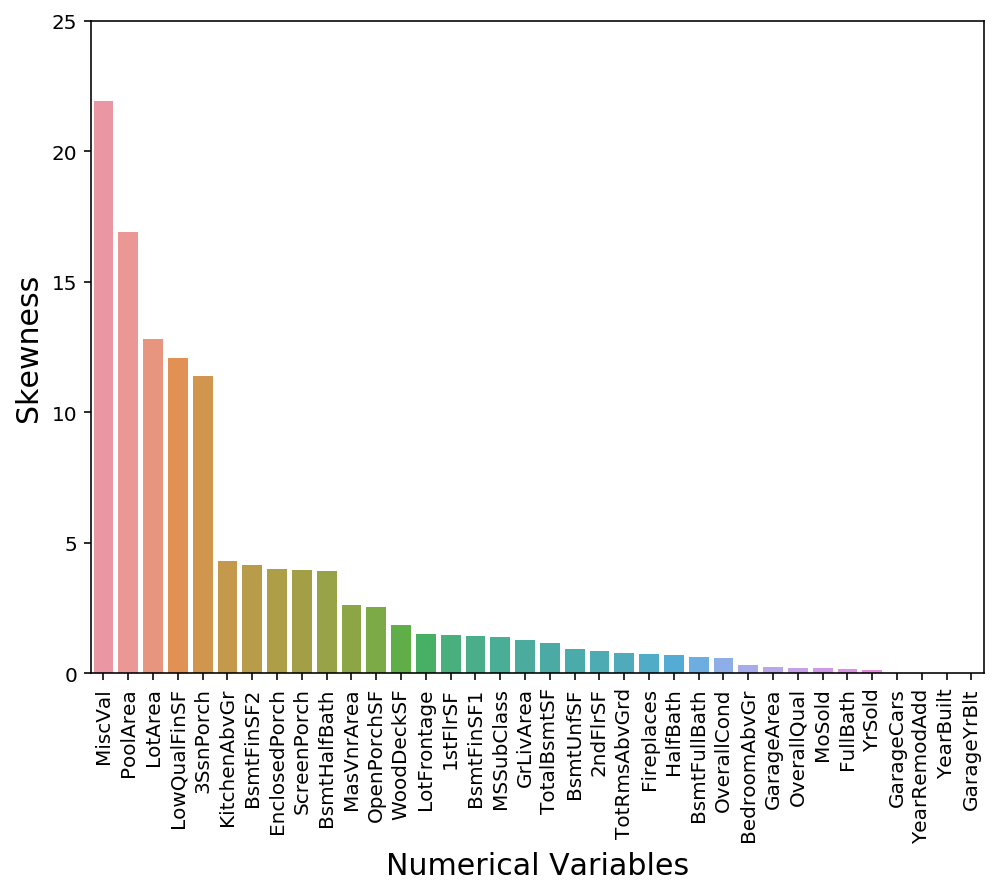

In [44]:
skewness = skewness.sort_values('Skewness', ascending=[0])

f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

Let's apply the logarithmic transformation to all the variables with a skewness above a certain threshold (0.75). Then, replot the skewness of attributes. Note that to have a fair comparison the two plots should have the same scale.

In [45]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
all_data[skewed_feats.index] = np.log1p(all_data[skewed_feats.index])

Text(0.5, 1.0, '')

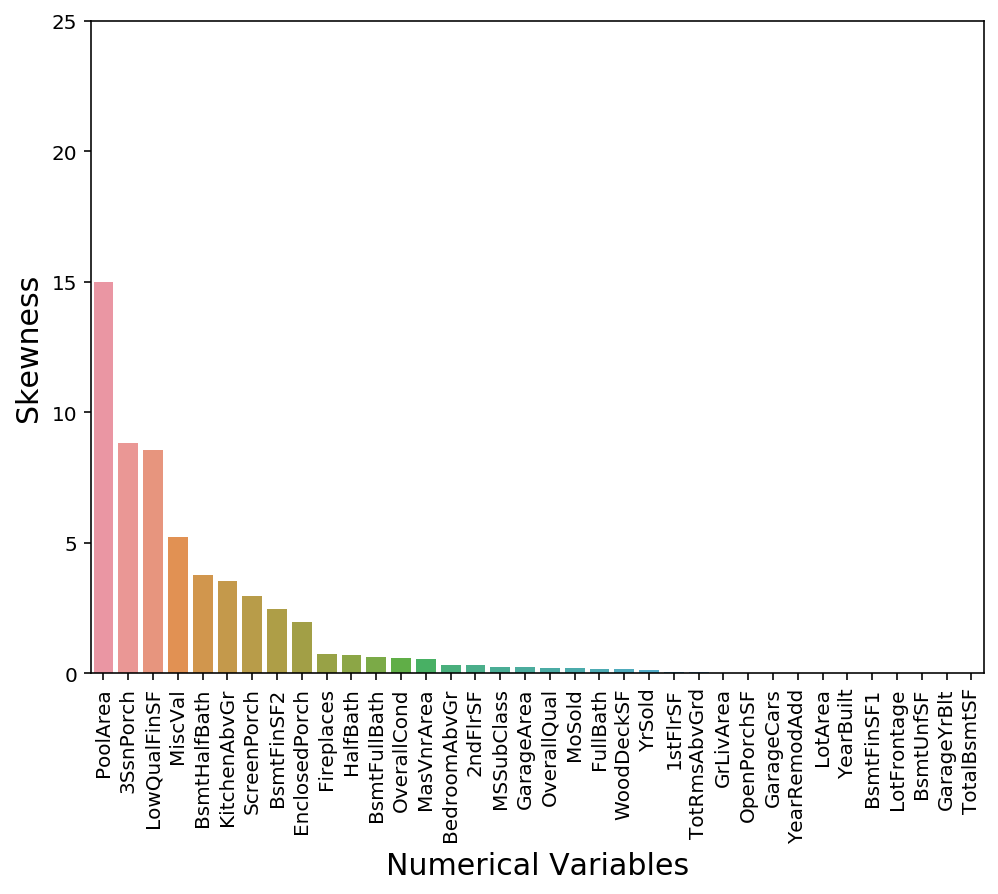

In [46]:
# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewness_new = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.values})
# select the variables with a skewness above a certain threshold

skewness_new = skewness_new.sort_values('Skewness', ascending=[0])

f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewness_new['Variable'], y=skewness_new['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

## Correlation Analysis
We can finally perform some correlation analysis.

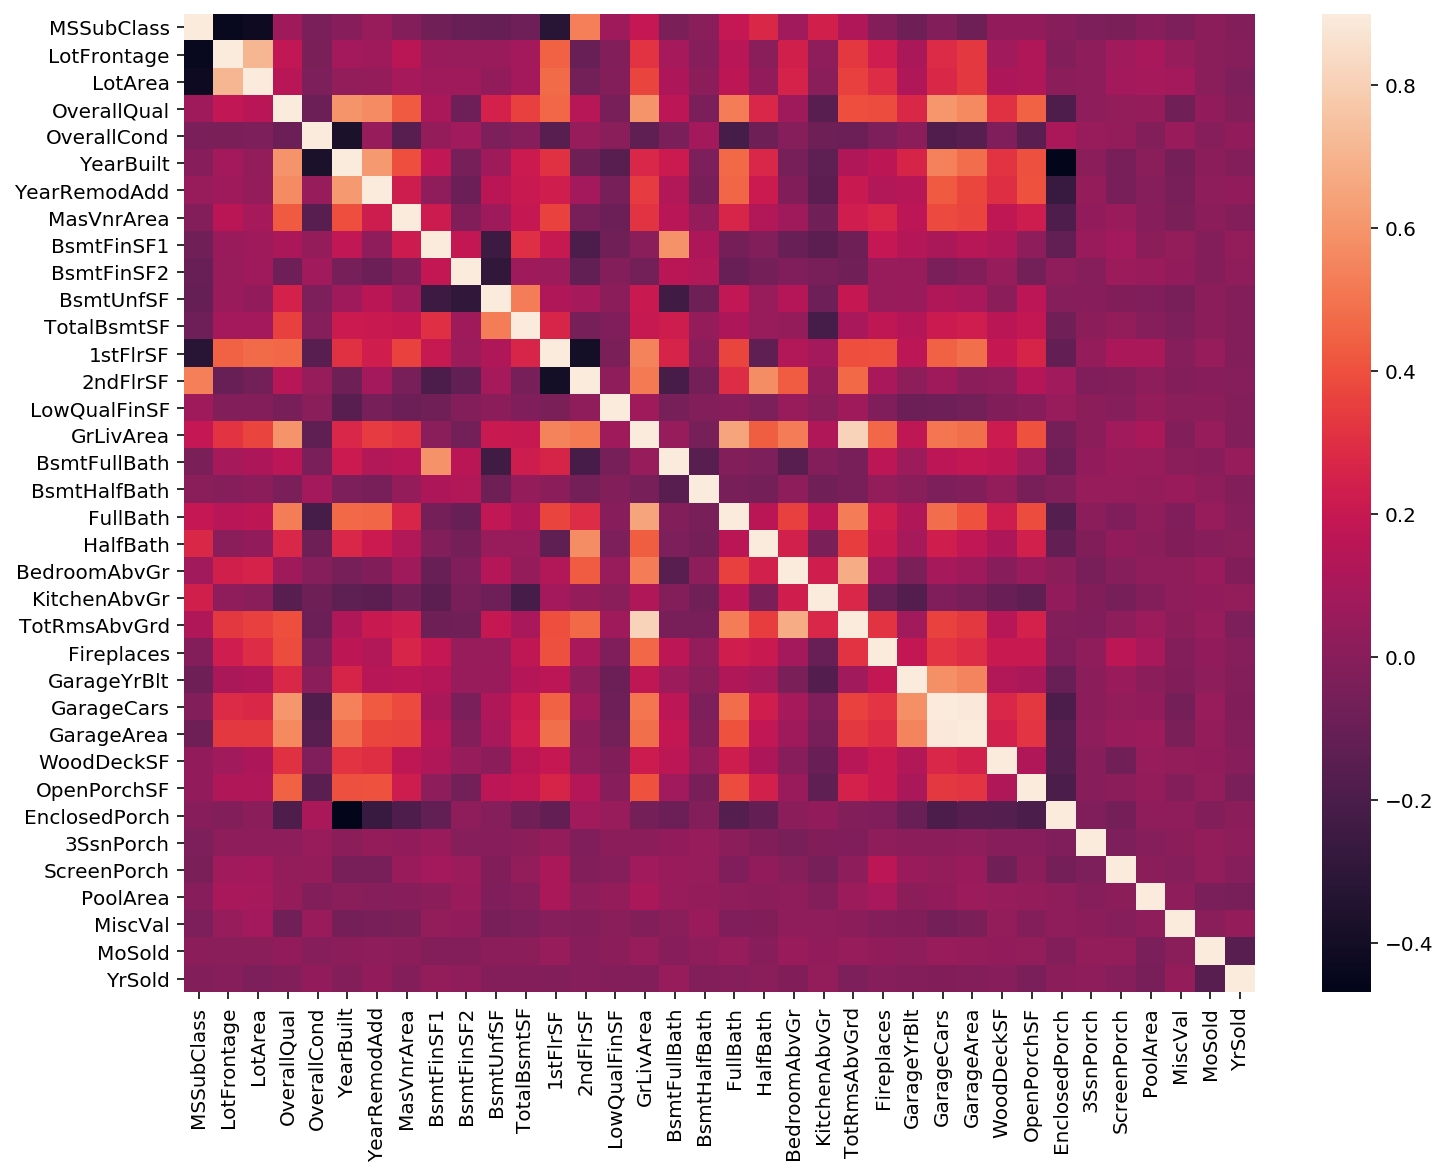

In [47]:
corrmat = all_data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9);

/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:1176: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


<Figure size 864x648 with 0 Axes>

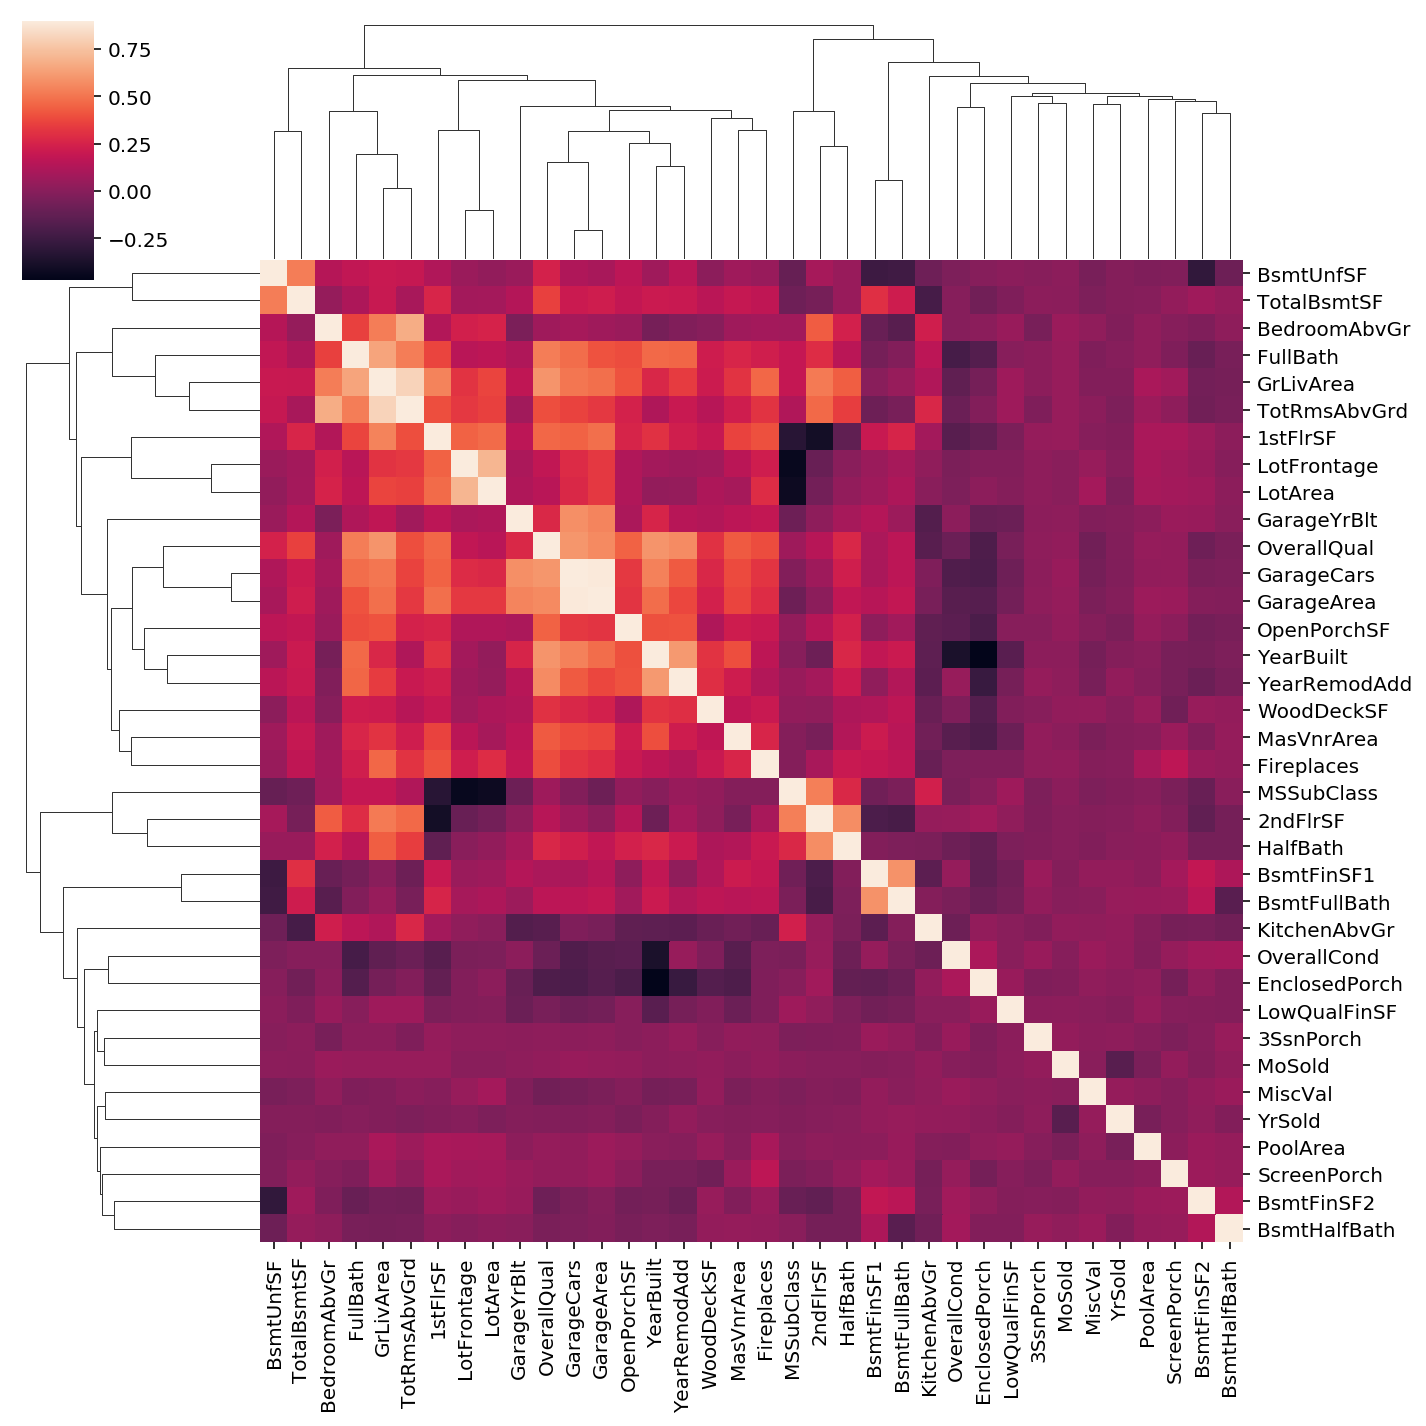

In [48]:
import seaborn as sns
plt.figure(figsize=(12,9))
sns.clustermap(corrmat, vmax=0.9, square=True);

Or we can further analyze the distribution of some variables.

## One Hot Encoding
We now generate the one hot encoding for all the categorical variables. Pandas has the function __get_dummies__ that generates the binary variables for all the categorical variables

In [49]:
print("Number of Variables before OHE: "+str(all_data.shape[1]))

Number of Variables before OHE: 78


In [50]:
all_data = pd.get_dummies(all_data)

In [51]:
print("Number of Variables after OHE: "+str(all_data.shape[1]))

Number of Variables after OHE: 300


## Saving the Preprocessed Data
We create the matrices to be used for computing the models and also save the cleaned data so that we can avoid repeating the process.

In [52]:
all_data.to_csv('HousePricesInputVariablesCleaned.csv')

In [53]:
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0
